# Trabajo 3. Aprendizaje Automático I
# Jorge Pablo Ávila Gómez

## Datos
Los datos provienen de la web InsideAirBnB, dedicada al estudio de los alquileres vacacionales
ofrecidos en la plataforma AirBnB. El fichero es una versión editada, a fin de facilitar la tarea, del listado original
de información sobre las ofertas existentes, para la ciudad de Madrid, en abril de 2017. Contiene
**13321 registros con 11 campos cada uno**, correspondientes a diferentes características de cada
oferta de alojamiento.

# Tarea Regresión
En este documento vamos a tratar la segunda parte del tercer trabajo de la asignatura que consiste en una tarea de regresión. Se usan los mismos datos que en el trabajo 1, siendo ```price``` la variable objetivo.

## 1. Importar los datos y un primer estudio estadístico:

In [1]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv("airbnb.csv")
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             13321 non-null  object 
 1   neighbourhood                   13321 non-null  object 
 2   latitude                        13321 non-null  float64
 3   longitude                       13321 non-null  float64
 4   room_type                       13321 non-null  object 
 5   price                           13321 non-null  int64  
 6   minimum_nights                  13321 non-null  int64  
 7   number_of_reviews               13321 non-null  int64  
 8   reviews_per_month               13321 non-null  float64
 9   calculated_host_listings_count  13321 non-null  int64  
 10  availability_365                13321 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


De aquí podemos observar ya algunas características importantes:
- Tenemos un dataset con un total de **11 columnas**
- con **13321 entradas**.
- Un dato muy importante es que no faltan datos en ninguna columna.
- Tenemos **3** variable de tipo `object`.
- El resto de variables (**8**) son **numéricas**.

In [2]:
## Podemos observar algunas filas del dataset
raw_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250


### 1.1 Estudio estadístico de las variables numéricas

In [3]:
raw_data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000
mean,40.420730,-3.697268,69.171834,3.010885,22.986037,1.520329,7.605885,205.867202
std,0.020344,0.023832,103.721126,12.835619,38.406006,1.852367,19.619972,126.968961
min,40.331888,-3.863907,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410090,-3.707856,31.000000,1.000000,1.000000,0.110000,1.000000,84.000000
50%,40.418731,-3.701602,53.000000,2.000000,7.000000,0.780000,2.000000,247.000000
75%,40.427997,-3.693818,80.000000,3.000000,28.000000,2.320000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,1125.000000,446.000000,17.210000,145.000000,365.000000


- Podemos observar de nuevo que no tenemos ``null values`` en las columnas numéricas, todas tiene 13321 valores.
- Es interesante que la columna ``price`` sean números enteros y el 50% de los valores entre 31 y 80, posiblemente sea el precio por noche.
- En la columna ``minimum_nights`` sorprende que el valor máximo sea 1125 que se corresponde con 1125/30/12 = 3 años, quizas es un poco raro para una oferta en airbnb.

Observamos ahora los histogramas de las diferentes variables:

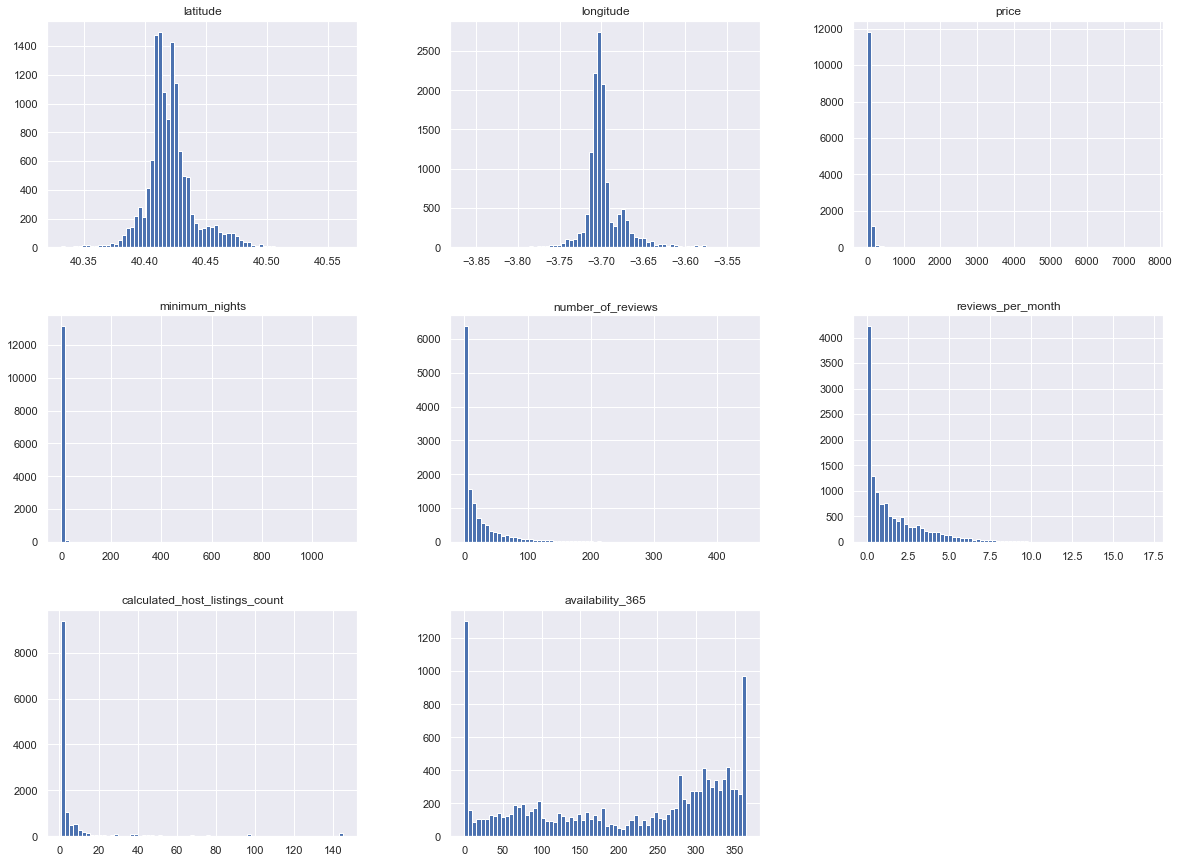

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

raw_data.hist(bins=70, figsize=(20, 15))
plt.show()

Aquí podemos observar que para variables como `price` o `minimum nights` la mayoría de los valores están cerca de 0. Habiendo valores muy lejanos de la mediana. Para `number of reviews`, `reviews per month` y `calculatred host listing count` las distribuciones son parecidas, pero con menos influencia de valores alejados. Por otro lado, `latitude` y `longitude` presentan distribuciones normales y la distribución de `availability 365` es aproximadamente uniforme.

En la tarea se recomienda estudiar las variables `price`, `minimum nights` y `calculatred host listing count` para ver si hay outliers. Con las gráficas y el estudio estadístico se ve claramente que presenta outliers, o por lo menos datos que se alejan bastante de las medias. Ya que en este estúdio no tenemos muchos valores diferentes (13321 no son demasiados), antes de eliminar los outlier, se ha considerado usar todos los valores proporcionados en el dataset y utilizar las transformaciones adecuadas para disminuir la influencia de los outliers.

En particular se va usar QuantileTransformer, el cual recalcula todos los valores entre 0 y 1, disminuyendo la influencia de los outliers.

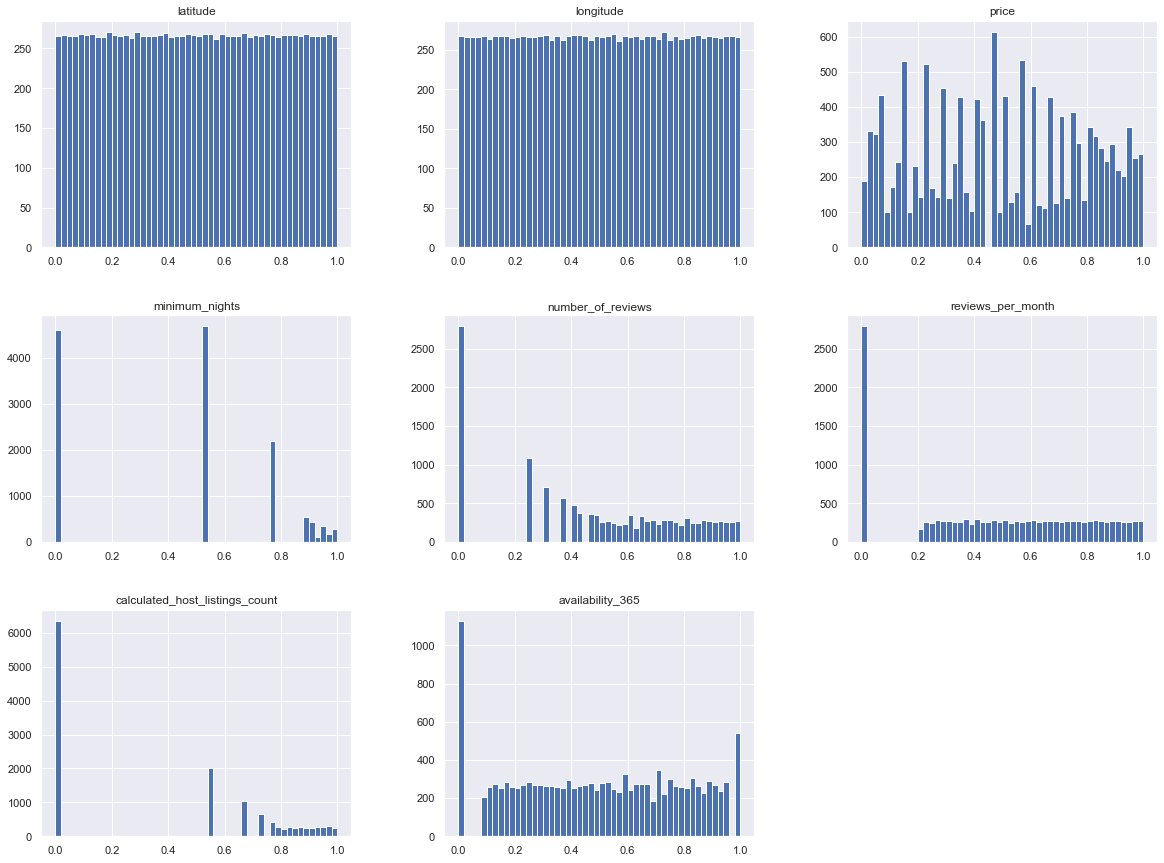

In [5]:
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

raw_data_n = raw_data.drop("room_type", axis=1)
ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
    ],
    remainder="drop",
)
data_t = ct.fit_transform(raw_data_n)
data_t = pd.DataFrame(data_t, columns=raw_data_n.columns[2:])
data_t.hist(bins=50, figsize=(20, 15))
plt.show()

### 1.2 Estudio de las variables categóricas

neighbourhood_group
Number of categories: 21
Centro                   6773
Chamberí                  960
Salamanca                 883
Arganzuela                790
Tetuán                    463
Moncloa - Aravaca         450
Retiro                    439
Latina                    379
Chamartín                 361
Carabanchel               358
Ciudad Lineal             308
Puente de Vallecas        222
Hortaleza                 185
Fuencarral - El Pardo     170
Usera                     145
San Blas - Canillejas     117
Villaverde                 83
Barajas                    81
Moratalaz                  74
Villa de Vallecas          46
Vicálvaro                  34
Name: neighbourhood_group, dtype: int64


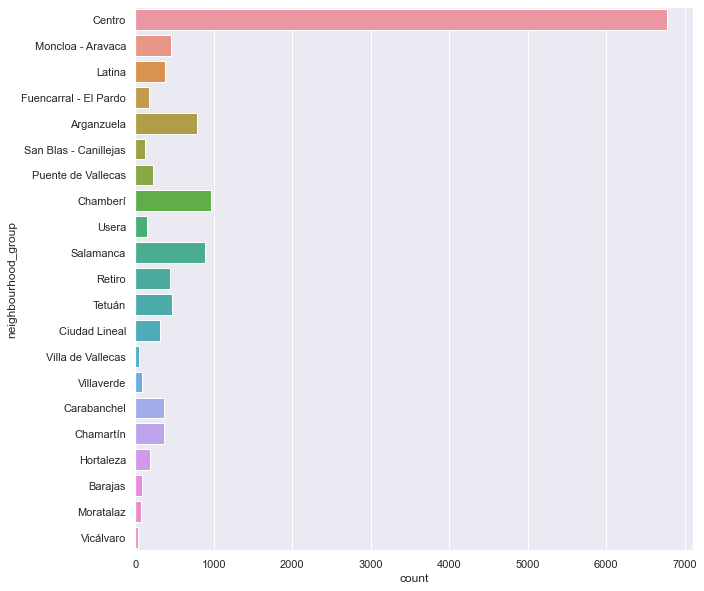

--------------------------------------------------
neighbourhood
Number of categories: 126
Embajadores       1848
Universidad       1363
Palacio           1084
Sol                942
Justicia           788
                  ... 
Rosas                4
Hellín               4
Cuatro Vientos       3
Orcasitas            2
El Pardo             1
Name: neighbourhood, Length: 126, dtype: int64


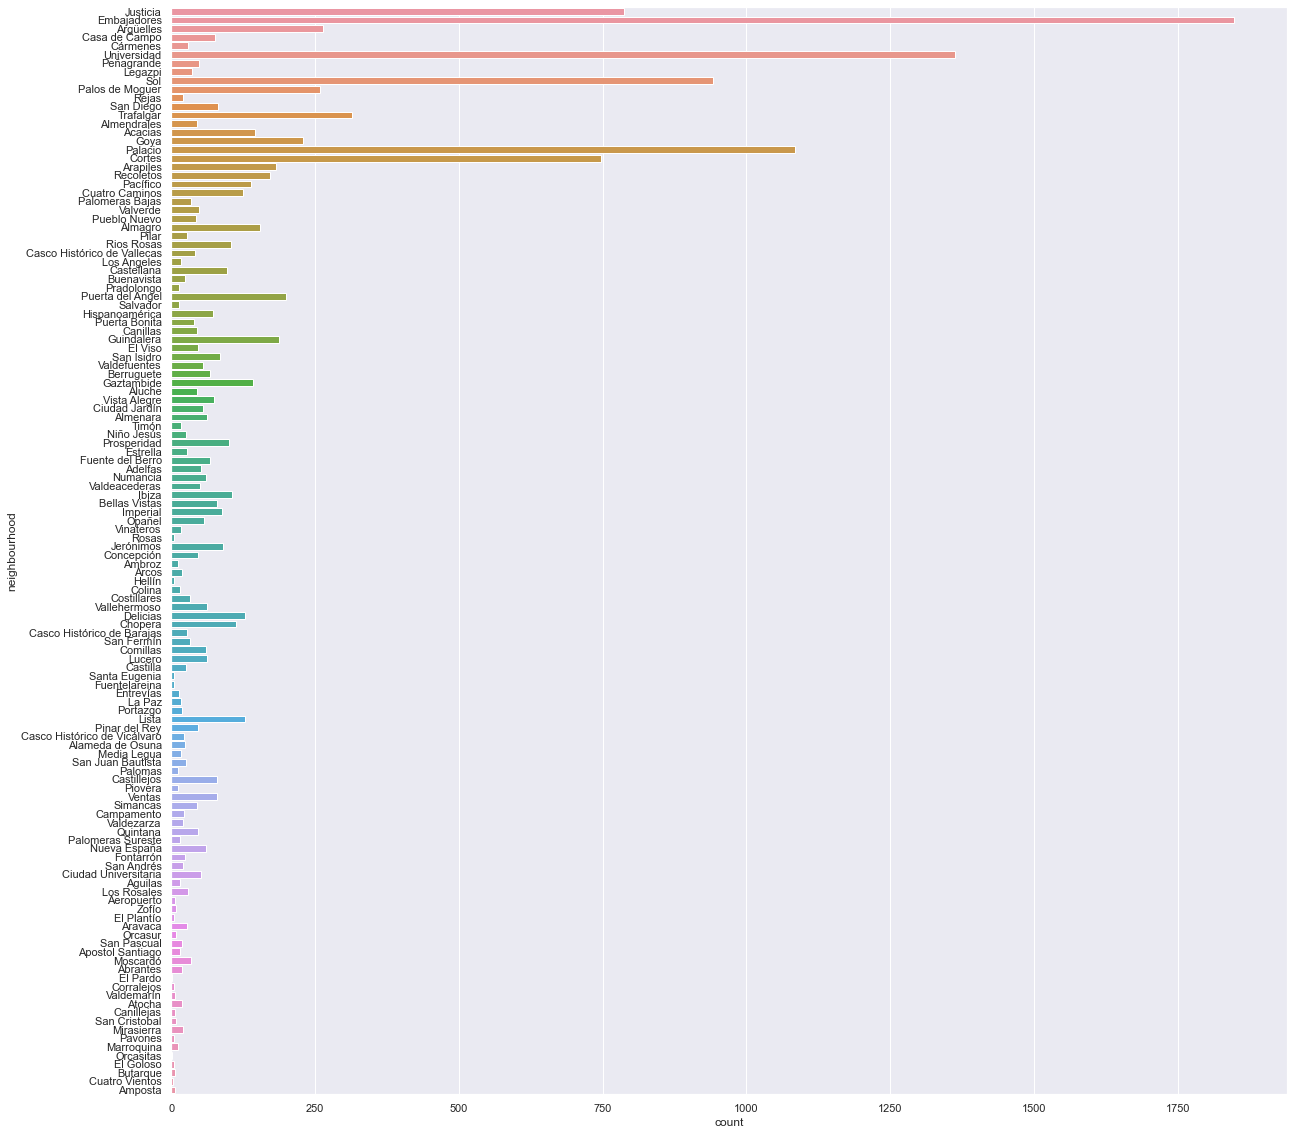

--------------------------------------------------
room_type
Number of categories: 3
Entire home/apt    7926
Private room       5203
Shared room         192
Name: room_type, dtype: int64


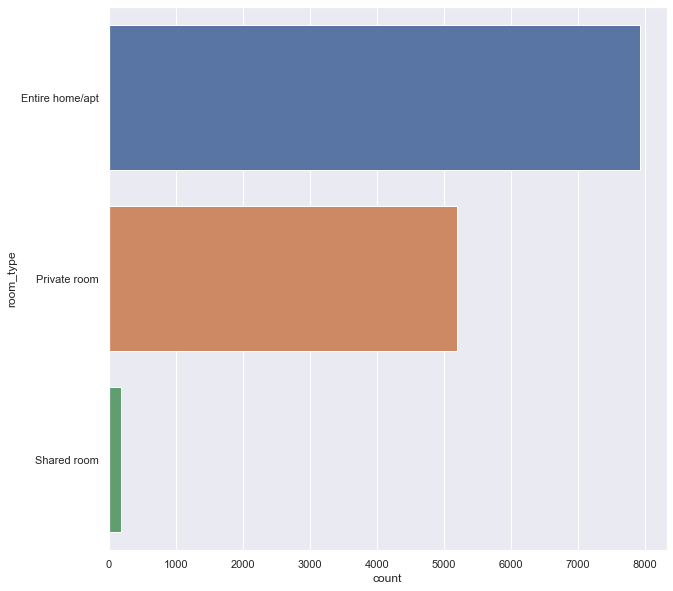

--------------------------------------------------


In [6]:
sizes = [(10, 10), (20, 20)]
for i, col in enumerate(raw_data.columns):
    if str(raw_data[col].dtypes) == "object":  # Only categorical columns
        print(col)
        print("Number of categories:", len(raw_data[col].unique()))
        print(raw_data[col].value_counts())  # The count of each different value

        plt.figure(figsize=sizes[i % 2])
        ax = sns.countplot(y=col, data=raw_data)  # Count plot

        plt.show()
        print("-" * 50)

- Observamos que para la variable `room type` tenemos solo 3 categorias diferentes pero están desbalanceadas, especialmente la categoría `Shared room` con solo 192 casos.
- Para la variable `neighbourhood` tenemos muchas categorías, 126, para `neighbourhood_group` tenemos menos, solo 21. Estas dos variables estarán posiblemente muy relacionadas (cada `neighbourhood_group` estará formado por un conjunto de `neighbourhood`).  
- Del mismo modo, las variables `latitude` y `longitude` codifican también información de localización, posiblemente estando correlacionadas con las variables `neighbourhood` y `neighbourhood_group`.

### 1.3 Estudiar si faltan datos

In [7]:
# Checking for missing values
raw_data.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

No falta ningún valor.

### 1.4 Esdudio correlación entre variables

Mediante el método ``corr`` se ha estudiado cuales son las variables que tienen una mayor correlación con la variable objetivo.

In [8]:
# Numeric variables
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        # ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
data_t = ct.fit_transform(raw_data)
data_t = pd.DataFrame(
    data_t,
    columns=[
        "latitude",
        "longitude",
        "price",
        "minimum_nights",
        "number_of_reviews",
        "reviews_per_month",
        "calculated_host_listings_count",
        "availability_365",
    ],
)
abs(data_t.corr()["price"]).sort_values(ascending=False)

price                             1.000000
minimum_nights                    0.218238
latitude                          0.128576
calculated_host_listings_count    0.111494
availability_365                  0.044972
number_of_reviews                 0.034694
longitude                         0.021472
reviews_per_month                 0.006870
Name: price, dtype: float64

Observamos que entre las diferentes variables numéricas no existe una correlación muy fuerte con *price*. Las variables con una correlación más alta son: *minimum_nights*, *latitude* y *calculated_host_listings_count*, con correlaciones entre 0.1 y 0.21.

In [9]:
# room_type
ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), ["price"]),
        ("cat", OneHotEncoder(), ["room_type"]),
    ],
    remainder="drop",
)
data_t = ct.fit_transform(raw_data)
col = ["price"]
col.extend(raw_data.room_type.unique())
data_t = pd.DataFrame(data_t, columns=col)
abs(data_t.corr()["price"]).sort_values(ascending=False)

price              1.000000
Entire home/apt    0.723989
Private room       0.693665
Shared room        0.142412
Name: price, dtype: float64

Con las diferentes clases de la variable categórica *room_type* vemos que existe una fuerte correlación. 0.72 para *Entire home/apt* y 0.69 para *Private room*. Esto tiene sentido ya que el tipo de apartamento suele afectar mucho al precio del alquiler, siendo más altos para casas enteras y menor si es solo una habitación. Como esta variable correlaciona muy bien con la variable objetivo, realizaremos una división estratificada del train y test set para tener muestras poblacionales lo más similares y equivalentes posibles.

In [10]:
# neighbourhood_group
ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), ["price"]),
        ("cat", OneHotEncoder(), ["neighbourhood_group"]),
    ],
    remainder="drop",
)
data_t = ct.fit_transform(raw_data)
col = ["price"]
col.extend(raw_data.neighbourhood_group.unique())
data_t = pd.DataFrame(data_t.todense(), columns=col)
abs(data_t.corr()["price"]).sort_values(ascending=False)

price                    1.000000
Fuencarral - El Pardo    0.236302
Salamanca                0.149481
Latina                   0.132040
Centro                   0.110825
Ciudad Lineal            0.105002
Puente de Vallecas       0.085127
Hortaleza                0.083086
Vicálvaro                0.071277
Carabanchel              0.063661
Villaverde               0.062172
Tetuán                   0.060993
Barajas                  0.048022
Chamartín                0.046759
Usera                    0.043938
Arganzuela               0.031659
Moncloa - Aravaca        0.030791
Moratalaz                0.027084
Chamberí                 0.025566
San Blas - Canillejas    0.024545
Villa de Vallecas        0.006462
Retiro                   0.000328
Name: price, dtype: float64

En la variable categórica *neighbourhood_group* encontramos algunas clases que presentan cierta correlación con la variable objetivo, con valores similares a las correlaciones de las variables numéricas, así que será interesante tener estas clases en el entrenamiento.

In [11]:
# neighbourhood
ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), ["price"]),
        ("cat", OneHotEncoder(), ["neighbourhood"]),
    ],
    remainder="drop",
)
data_t = ct.fit_transform(raw_data)
col = ["price"]
col.extend(raw_data.neighbourhood.unique())
data_t = pd.DataFrame(data_t.todense(), columns=col)
abs(data_t.corr()["price"]).sort_values(ascending=False)

price                1.000000
El Pardo             0.142684
El Viso              0.106758
Fontarrón            0.098630
Palomeras Sureste    0.096136
                       ...   
Pueblo Nuevo         0.001022
Palacio              0.000990
Puerta del Angel     0.000799
San Pascual          0.000599
Buenavista           0.000273
Name: price, Length: 127, dtype: float64

La variable categórica *neighbourhood* presenta algunas clases con cierta correlación aunque no demasiado alta. Como se indica en el enunciado de la actividad, se estudiará la influencia de esta variable en los resultados del entrenamiento.

## 2. Preparación del test set

In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(
    raw_data, test_size=0.2, random_state=88, stratify=raw_data.room_type
)

X_train = train_set.drop("price", axis=1)
y_train = train_set.price

- Se han dividido los datos en un `train_set` y un `test_set` del 20% de los datos. 
- Se ha realizadido una división estratificada según las clases de la columna objetivo `room type`. Al estar fuertemente correlacionada la variable `room type` con la variable objetivo es interesante que la distribución, no balanceada, de las clases se mantenga en el `train_set` y `test_set`. 

## 3. LinearSVR

En este apartado vamos a realizar el entrenamiento del modelo LinearSVR usando sus parámetros por defecto. El único parámetro que se ha añadido es el número de iteraciones que se ha subido a 10000 para evitar errores de convergencia.

In [13]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score

X_train = train_set.drop("price", axis=1)
y_train = train_set.price

model = LinearSVR(max_iter=10000)

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

results = cross_val_score(
    model, X_train_t, y_train_t, cv=10, scoring="neg_mean_squared_error"
)
print("RMSE:", results.mean())
# error equivalence in 'price' units
print(
    "Error in 'price' units: ",
    y_transformer.inverse_transform(np.sqrt(abs(results.mean())).reshape(1, -1)),
)

RMSE: -0.03331793834728053
Error in 'price' units:  [[27.]]


Hemos utilizado como métrica de puntuación la RMSE. Para este modelo hemos obtenido -0.0333 usando validación cruzada. El resultado es negativo porque scikitlearn usa el convenio de que un número mayor debe simbolizar una puntuación mejor, para RMSE un modelo mejor tiene un valor más cerca de 0 por tanto al usar el negativo de RMSE los números mayores son menos negativos y están más cerca de cero.

En la última línea se realiza una transformación inversa para obtener el error en unidades de la variable price. Obtenemos un error de 27. En la variable price, el 75% de los datos se encuentran entre 9 y 80, por tanto obtenemos un error relativamente importante.

Para comprabar empíricamente la influencia de los outlier, se va a entrenar el mismo modelo anterior pero eliminando las entradas en las que la variable price es mayor que 1000, de las cuales tenemos 6 en el dataset.

In [14]:
sum(y_train > 1000)

6

In [15]:
# eliminando outlier en price
X_train = train_set[train_set.price < 1000].drop("price", axis=1)
y_train = train_set[train_set.price < 1000].price

model = LinearSVR(max_iter=10000)

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

results = cross_val_score(
    model, X_train_t, y_train_t, cv=10, scoring="neg_mean_squared_error"
)
print("RMSE:", results.mean())
# error equivalence in 'price' units
print(
    "Error in 'price' units: ",
    y_transformer.inverse_transform(np.sqrt(abs(results.mean())).reshape(1, -1)),
)

RMSE: -0.033263514701821525
Error in 'price' units:  [[27.]]


En este modelo en el que hemos eliminado los posibles outliers obtenemos una puntuación de: -0.0332 equivaliendo a 27 en unidades de price. El error ha disminuido un poco con respecto al modelo anterior, aunque este efecto es muy pequeño y no cambia el error medido en unidades de price. Por tanto, se considera que no hay una mejora sustancial en la eliminación de estos datos y que es mejor entrenar con todos para poder predecir este tipo de entradas en el futuro.

Como se pide en el enunciado, se prodece a estudiar el modelo sin la variable *neighbourhood*:

In [16]:
# sin neighbourhood
X_train = train_set.drop("price", axis=1)
X_train = X_train.drop("neighbourhood", axis=1)
y_train = train_set.price

model = LinearSVR(max_iter=10000)

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

results = cross_val_score(
    model, X_train_t, y_train_t, cv=10, scoring="neg_mean_squared_error"
)
print("RMSE:", results.mean())
# error equivalence in 'price' units
print(
    "Error in 'price' units: ",
    y_transformer.inverse_transform(np.sqrt(abs(results.mean())).reshape(1, -1)),
)

RMSE: -0.03457882548616677
Error in 'price' units:  [[27.]]


En el modelo que no incluye la variable *neighbourhood* se obtiene un error de -0.0345, muy parecido al de los modelos anteriores aunque relativamente superior. Se pierde un poco de capacidad de predicción al eliminar esta variable.

## 4. SVR

En este apartado vamos a realizar el entrenamiento del modelo SVR usando sus parámetros por defecto.

In [17]:
from sklearn.svm import SVR

X_train = train_set.drop("price", axis=1)
y_train = train_set.price

model = SVR()

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

results = cross_val_score(
    model, X_train_t, y_train_t, cv=10, scoring="neg_mean_squared_error"
)
print("RMSE:", results.mean())
# error equivalence in 'price' units
print(
    "Error in 'price' units: ",
    y_transformer.inverse_transform(np.sqrt(abs(results.mean())).reshape(1, -1)),
)

RMSE: -0.030368159285561157
Error in 'price' units:  [[26.]]


Usando el modelo SVR con todas las variables obtenemos una RMSE de -0.03036, que equivale en unidades de price a 26. Comparando con el modelo LinearSVR los errores son menores en este caso.

In [18]:
# sin neighbourhood
X_train = train_set.drop("price", axis=1)
X_train = X_train.drop("neighbourhood", axis=1)
y_train = train_set.price

model = SVR()

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

results = cross_val_score(
    model, X_train_t, y_train_t, cv=10, scoring="neg_mean_squared_error"
)
print("RMSE:", results.mean())
# error equivalence in 'price' units
print(
    "Error in 'price' units: ",
    y_transformer.inverse_transform(np.sqrt(abs(results.mean())).reshape(1, -1)),
)

RMSE: -0.03068993740978665
Error in 'price' units:  [[26.]]


Cuando usando el modelo SVR sin la variable neighbourhood obtenemos una RMSE de -0.03068, que equivale en unidades de price a 26. Tenemos errores prácticamente idénticos al modelo que usa todas las variables.

## 5. Comparación entre los modelos

Comparando los modelos LinearSVR y SVR, el modelo SVR consigue puntuaciones mejores de 0.030 con respecto a 0.033 para LinearSVR. Por tanto, se procederá a realizar la hiperparametrización al modelo SVR.

Por otro lado, con respecto a la variable *neighbourhood* para los dos modelos se produce un ligero aumento del error. Este aumento es muy pequeño, en el orden de 0.001. Al tener mejores RMSE los modelos que incluyen la variable *neighbourhood* el proceso de hiperparametrización se va a realizar incluyéndola, ya que parece que incorpora, aunque poca, cierta información que mejora ligeramente los modelos.

## 6. Hiperparametrización SVR

Para la afinación de los hiperparámetros se va a realizar la optimización de C y gamma, en el modelo SVR usando el kernel *rbf*. En el proceso se van a utilizar todas las variables. La busqueda de los hiperparámetros se va a realizar usando GridSearchCV, con 10 partes de validación cruzada. Se usa el parámentro verbose = 2 para ajustar el nivel de mensajes durante la busqueda, y el parámetro n_jobs a -2, el cual sirve para indicar que se usen todos los núcleos menos 1 (acelerando la busqueda, pero deja un núcleo libre para poder usar mientras tanto el ordenador). 

Para la busqueda de los hiperparámetros se ha seguido la sugerencia de realizar varias busquedas ajustando los intervalos. Para la primera busqueda se ha usado un rango espaciado en escala logarítmica entre 0.001 y 100 usando la función np.logspace.

In [19]:
# Rango de los parámetros para la primera busqueda
np.logspace(-3, 2.0, num=6)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [20]:
from sklearn.model_selection import GridSearchCV

X_train = train_set.drop("price", axis=1)
# X_train = X_train.drop("neighbourhood", axis=1)
y_train = train_set.price

model = SVR()

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

param_grid = [{"C": np.logspace(-3, 2.0, num=6), "gamma": np.logspace(-3, 2.0, num=6)}]

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    verbose=2,
    n_jobs=-2,
)

scores_gs = grid_search.fit(X_train_t, y_train_t)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-2)]: Done 360 out of 360 | elapsed: 19.7min finished


In [21]:
print("Model: SVR(kernel='rbf')")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"RMSE: {scores_gs.best_score_:0.4f}")  # Best RMSE

Model: SVR(kernel='rbf')
Best parameters: {'C': 1.0, 'gamma': 0.1}
RMSE: -0.0302


Tras la primera ronda de busqueda se han obtenido los valores: ```{'C': 1.0, 'gamma': 0.1}```. Partiendo de estos valores ahora realizaremos otra busqueda con escala locarítmica con los valores obtenidos en el centro del intervalo.

In [22]:
print("C: ", np.logspace(-1, 1.0, num=10))

C:  [ 0.1         0.16681005  0.27825594  0.46415888  0.77426368  1.29154967
  2.15443469  3.59381366  5.9948425  10.        ]


In [23]:
print("gamma: ", np.logspace(-2, 0, num=10))

gamma:  [0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]


In [24]:
from sklearn.model_selection import GridSearchCV

X_train = train_set.drop("price", axis=1)
# X_train = X_train.drop("neighbourhood", axis=1)
y_train = train_set.price

model = SVR()

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

param_grid = [{"C": np.logspace(-1, 1.0, num=10), "gamma": np.logspace(-2, 0, num=10)}]

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    verbose=2,
    n_jobs=-2,
)

scores_gs = grid_search.fit(X_train_t, y_train_t)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-2)]: Done 642 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed: 33.1min finished


In [25]:
print("Model: SVR(kernel='rbf')")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"RMSE: {scores_gs.best_score_:0.4f}")

Model: SVR(kernel='rbf')
Best parameters: {'C': 0.2782559402207124, 'gamma': 0.21544346900318834}
RMSE: -0.0301


Tras la segunda ronda de busqueda se han obtenido los valores: ```{'C': 0.2782559402207124, 'gamma': 0.21544346900318834}```. Partiendo de estos valores se va a realizar otra busqueda usando ahora una escala lineal.

In [26]:
print("C: ", np.linspace(0.16681005, 0.46415888, 10))

C:  [0.16681005 0.19984881 0.23288757 0.26592633 0.29896509 0.33200384
 0.3650426  0.39808136 0.43112012 0.46415888]


In [27]:
print("gamma: ", np.linspace(0.12915497, 0.35938137, 10))

gamma:  [0.12915497 0.15473568 0.18031639 0.2058971  0.23147781 0.25705853
 0.28263924 0.30821995 0.33380066 0.35938137]


In [28]:
from sklearn.model_selection import GridSearchCV

X_train = train_set.drop("price", axis=1)
# X_train = X_train.drop("neighbourhood", axis=1)
y_train = train_set.price

model = SVR()

ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

X_train_t = ct.fit_transform(X_train)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()

param_grid = [
    {
        "C": np.linspace(0.16681005, 0.46415888, 10),
        "gamma": np.linspace(0.12915497, 0.35938137, 10),
    }
]

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=10,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    verbose=2,
    n_jobs=-2,
)

scores_gs = grid_search.fit(X_train_t, y_train_t)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 156 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-2)]: Done 359 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-2)]: Done 642 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed: 31.2min finished


In [29]:
print("Model: SVR(kernel='rbf')")
print(f"Best parameters: {scores_gs.best_params_}")  # Best parameters
print(f"RMSE: {scores_gs.best_score_:0.4f}")
print(
    "Error in 'price' units: ",
    y_transformer.inverse_transform(np.sqrt(abs(scores_gs.best_score_)).reshape(1, -1)),
)

Model: SVR(kernel='rbf')
Best parameters: {'C': 0.23288756777777775, 'gamma': 0.20589710333333333}
RMSE: -0.0301
Error in 'price' units:  [[26.]]


Tras el proceso de optimización de los hiperparámetros se obtiene una RMSE de 0.0301, que es ligeramente inferior a la obtenida antes de la optimización (0.0302). Los parámetros obtenidos en la tercera busqueda son muy parecidos a los de la segunda por tanto, no se prevé una mejora en RMSE si se continúa realizando más busquedas de los hiperparámetros. El equivalente al error en unidades de price es 26, que es relativamente alto para el rango de valores que toma la variable.

## 7. Evaluación del Test set

Se ha evaluado el test set usando el modelo obtenido tras la hiperparametrización.

In [30]:
from sklearn.metrics import mean_squared_error

# Model: SVR(kernel='rbf')

# Preparation of X and y from the test_set and train_set
X_test = test_set.drop("price", axis=1)
y_test = test_set.price
X_train = train_set.drop("price", axis=1)
y_train = train_set.price

# A column transformer with QuantileTransformer for the numeric variables
# and OneHotEncoder for the categorical variables
ct = ColumnTransformer(
    [
        ("num", QuantileTransformer(), make_column_selector(dtype_include=np.number)),
        ("cat", OneHotEncoder(), make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
)
y_transformer = QuantileTransformer()

# Transformation of the train and test X
X_train_t = ct.fit_transform(X_train)
X_test_t = ct.transform(X_test)
y_train_t = y_transformer.fit_transform(pd.DataFrame(y_train)).ravel()
y_test_t = y_transformer.transform(pd.DataFrame(y_test)).ravel()

# Load the model from GridSearch
best_model = scores_gs.best_estimator_
# Fit the model
best_model.fit(X_train_t, y_train_t)
# Predict
y_pred = best_model.predict(X_test_t)

# Print the results
print("Model: SVR(kernel='rbf')")
print(f"Parameters: {scores_gs.best_estimator_}")  # Parameters
print(f"RMSE: {mean_squared_error(y_test_t, y_pred):0.4f}")  # Accuracy
print(
    "Error in 'price' units: ",
    y_transformer.inverse_transform(np.sqrt(abs(scores_gs.best_score_)).reshape(1, -1)),
)

Model: SVR(kernel='rbf')
Parameters: SVR(C=0.23288756777777775, gamma=0.20589710333333333)
RMSE: 0.0302
Error in 'price' units:  [[26.]]


Evaluando el modelo obtenido tras la hiperparametrización con el test set, obtenemos una RMSE de 0.0302, con un error equivalente en unidades de price de 26. El RMSE es solo 0.0001 mayor que en el train set tras la hiperparametrización. Lo cual nos indica que el modelo no ha sufrido overfitting y que puede ser usado para precedir precios en datos fuera de los usados durante el entrenamiento.

## 8. Conclusiones

En esta parte del trabajo se ha realizado una tarea de regresión para los datos de airBnB ya estudiados en el trabajo 1. Se han usado modelos de maquinas de vectores de soporte para predecir la variable objetivo price.

Se ha estudiado la correlación entre las diferentes variables y se ha encontrado que la variable room type está muy correlacionada con la variable objetivo, por tanto se ha realizado una división estratificada por la variable room type para generar el train y test set. Se ha usado dos modelos LinearSVR y SVR. Primero se han entrenado los modelos usando los parámetros por defecto y también, se ha estudiado la influencia de la variable neighbourhood. Las mejores puntuaciones se han obtenido con el modelo SVR incluyendo la variable neighbourhood, llegando a un RMSE de 0.0303.

Por último, se ha estudiado la hiperparametrización en el modelo SVR usando el kernel *rbf*. Se han optimizado los parámetros gamma y C. Para la optimización se han realizado 3 iteraciones sucesivas de busqueda, disminuyendo el rango tras cada iteración. Las dos primeras estaban logarítmicamente equiespaciadas y la última linealmente. Tras el proceso de hiperparametrización se mejoró la RMSE a 0.0301. Con un error equivalente en unidades de price de 26.

Al evaluar el modelo final con el test set se mantuvo un RMSE alto (0.0302), comparable con los resustados del entrenamiento. El valor de error en unidades de price equivale a 26, esto significa que a la hora de predecir precios de pisos no va a ser muy exacto si sus precios rondan el valor del error, pero para predecir alquileres más altos (~>100) las prediciones del modelo pueden ser muy útiles.